In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ultralytics import YOLO
from inference_sdk import InferenceHTTPClient

# =========================
# 1. Load Image for Detection
# =========================
image_path = "/Users/amanchandel/Work/projects/MCV2/floorplans/6.jpg"  # Replace with your image path

image = cv2.imread(image_path)

CLIENT = InferenceHTTPClient(
    api_url="https://outline.roboflow.com",
    api_key="v2GziEyR9s8BL6d96UGm"
)

# =========================
# 2. Load YOLOv8 Model for Object Detection
# =========================
# Load the YOLOv8 model (use custom-trained model if available)
model = YOLO('yolov8n.pt')  # Use yolov8n.pt for general objects or 'best.pt' if you train a custom model

# =========================
# 3. Run YOLOv8 Detection on the Image
# =========================
result = CLIENT.infer(image, model_id="floor-plan-segmentation-dtr4r/3")

# results = model.predict(image, conf=0.25)  # Detect objects with a confidence threshold of 25%
# results[0].plot()  # Call plot() on the first result in the list to visualize the results

In [53]:
detections = results[0].boxes  # YOLOv8 provides all bounding boxes in results[0]
class_map = {0: 'Wall', 1: 'Door', 2: 'Window', 3: 'Furniture'}  # Custom mapping of classes
coordinates = []

for box in detections:
    x1, y1, x2, y2 = box.xyxy[0]  # Extract box coordinates
    label = box.cls  # Extract class label
    confidence = box.conf  # Extract confidence score
    
    if confidence > 0.5:  # Filter boxes with low confidence
        coordinates.append({
            'x1': int(x1),
            'y1': int(y1),
            'x2': int(x2),
            'y2': int(y2),
            'class': int(label),
            'class_name': class_map.get(int(label), 'Unknown')
        })

print("Detected Object Coordinates: ", coordinates)

Detected Object Coordinates:  []


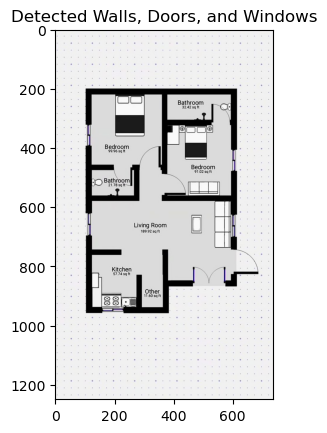

In [55]:
for item in coordinates:
    x1, y1, x2, y2 = item['x1'], item['y1'], item['x2'], item['y2']
    class_name = item['class_name']
    color = (0, 255, 0) if class_name == 'Wall' else (255, 0, 0)  # Green for wall, Red for door/window
    
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # Draw the rectangle
    cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Add class label

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Walls, Doors, and Windows")
plt.show()

In [57]:
wall_coords = [c for c in coordinates if c['class_name'] == 'Wall']
door_coords = [c for c in coordinates if c['class_name'] == 'Door']
window_coords = [c for c in coordinates if c['class_name'] == 'Window']

print(f"Total wall objects detected: {len(wall_coords)}")

# =========================
# 7. Save Coordinates to CSV for Debugging
# =========================
with open("detected_coordinates.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["X1", "Y1", "X2", "Y2", "Class", "Class Name"])
    for item in coordinates:
        writer.writerow([item['x1'], item['y1'], item['x2'], item['y2'], item['class'], item['class_name']])

print("Coordinates saved to detected_coordinates.csv")

Total wall objects detected: 0
Coordinates saved to detected_coordinates.csv


In [63]:
wall_height = 5  # Height of the wall in 3D
wall_planes = []

for wall in wall_coords:
    x1, y1, x2, y2 = wall['x1'], wall['y1'], wall['x2'], wall['y2']
    wall_planes.append([
        [x1, y1, 0],  # Bottom-left
        [x2, y1, 0],  # Bottom-right
        [x2, y2, wall_height],  # Top-right
        [x1, y2, wall_height]  # Top-left
    ])

if wall_planes:
    # =========================
    # 9. Plot 3D Walls Using Matplotlib
    # =========================
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for wall in wall_planes:
        vertices = [
            [wall[0], wall[1], wall[2], wall[3]]  # 4 corners of the wall
        ]
        poly3d = Poly3DCollection(vertices, alpha=0.8, facecolor='gray', edgecolor='k')
        ax.add_collection3d(poly3d)

    ax.set_xlim(0, max([w[0][0] for w in wall_planes]))
    ax.set_ylim(0, max([w[0][1] for w in wall_planes]))
    ax.set_zlim(0, wall_height)

    plt.title("3D Wall Model")
    plt.show()
else:
    print("No wall objects detected. Skipping 3D visualization.")

No wall objects detected. Skipping 3D visualization.


ImportError: dlopen(/Users/amanchandel/anaconda3/lib/python3.12/site-packages/open3d/macos/open3d.so, 0x0002): tried: '/usr/local/lib/open3d.so' (no such file), '/usr/local/lib/open3d.so' (no such file), '/usr/local/lib/open3d.so' (no such file), '/usr/local/lib/open3d.so' (no such file), '/open3d.so' (no such file), '/Users/amanchandel/anaconda3/lib/python3.12/site-packages/open3d/macos/open3d.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/amanchandel/anaconda3/lib/python3.12/site-packages/open3d/macos/open3d.so' (no such file), '/Users/amanchandel/anaconda3/lib/python3.12/site-packages/open3d/macos/open3d.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))